In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [2]:
#Load the dataset
df = pd.read_csv('C:.../new_df.csv')

In [3]:
#Information about the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50253 entries, 0 to 50252
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  50253 non-null  int64 
 1   tmsp        50253 non-null  object
 2   country     50253 non-null  object
 3   amount      50253 non-null  int64 
 4   success     50253 non-null  int64 
 5   PSP         50253 non-null  object
 6   3D_secured  50253 non-null  int64 
 7   card        50253 non-null  object
dtypes: int64(4), object(4)
memory usage: 3.1+ MB


In [4]:
# Convert the timestamp column to datetime & Extract new features
df['tmsp'] = pd.to_datetime(df['tmsp'])
df['month'] = df['tmsp'].dt.month
df['weekday'] = df['tmsp'].dt.weekday  # Monday=0, Sunday=6
print(df.head())

   Unnamed: 0                tmsp  country  amount  success         PSP  \
0           0 2019-01-01 00:01:11  Germany      89        0     UK_Card   
1           1 2019-01-01 00:01:17  Germany      89        1     UK_Card   
2           2 2019-01-01 00:02:49  Germany     238        0     UK_Card   
3           3 2019-01-01 00:03:13  Germany     238        1     UK_Card   
4           4 2019-01-01 00:04:33  Austria     124        0  Simplecard   

   3D_secured    card  month  weekday  
0           0    Visa      1        1  
1           0    Visa      1        1  
2           1  Diners      1        1  
3           1  Diners      1        1  
4           0  Diners      1        1  


In [5]:
# Function to flag unique transactions
def flag_unique_transactions(group):
    group['time_diff'] = group['tmsp'].diff().dt.total_seconds().fillna(0)
    group['unique_transaction'] = (group['time_diff'] > 60) | (group['time_diff'] == 0)
    return group

# Apply the function to each group of transactions with the same country and amount
df = df.groupby(['country', 'amount']).apply(flag_unique_transactions)

# Filter the DataFrame for unique transactions
unique_transactions = df[df['unique_transaction']]

# Drop helper columns
unique_transactions = unique_transactions.drop(columns=['time_diff', 'unique_transaction'])

C:\Users\Ezgi\AppData\Local\Temp\ipykernel_10992\1489304741.py:8: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby(['country', 'amount']).apply(flag_unique_transactions)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50253 entries, 0 to 50252
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Unnamed: 0          50253 non-null  int64         
 1   tmsp                50253 non-null  datetime64[ns]
 2   country             50253 non-null  object        
 3   amount              50253 non-null  int64         
 4   success             50253 non-null  int64         
 5   PSP                 50253 non-null  object        
 6   3D_secured          50253 non-null  int64         
 7   card                50253 non-null  object        
 8   month               50253 non-null  int64         
 9   weekday             50253 non-null  int64         
 10  time_diff           50253 non-null  float64       
 11  unique_transaction  50253 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(6), object(3)
memory usage: 5.7+ MB


In [7]:
#Converting data type of unique_transaction to object
df['unique_transaction'] = df['unique_transaction'].replace({False: 'no', True: 'yes'})
df['unique_transaction'] = df['unique_transaction'].astype('object')
categories_unique_transaction = df['unique_transaction'].unique()
print(categories_unique_transaction)
print(df['unique_transaction'].dtype)

['yes' 'no']
object


In [8]:
#Converting data type of success to object
df['success'] = df['success'].replace({0: 'failure', 1: 'successful'})
categories_success = df['success'].unique()
print(categories_success)
df['success'] = df['success'].astype('object')
print(df['success'].dtypes)

['failure' 'successful']
object


In [9]:
#Converting data type of 3D_secured to object
df['3D_secured'] = df['3D_secured'].replace({0: 'no', 1: 'yes'})
categories_3D_secured = df['3D_secured'].unique()
df['3D_secured'] = df['3D_secured'].astype('object')
print(categories_3D_secured)
print(df['3D_secured'].dtypes)

['no' 'yes']
object


In [10]:
#Converting data type of month to object
df['month'] = df['month'].replace({1: 'january',2: 'february'})
categories_month = df['month'].unique()
df['month'] = df['month'].astype('object')
print(categories_month)
print(df['month'].dtypes)

['january' 'february']
object


In [11]:
df['weekday'] = df['weekday'].replace({0: 'monday', 1: 'tuesday', 2: 'wednesday', 3: 'thursday', 4:'friday', 5:'saturday', 6:'sunday'})
categories_weekday = df['weekday'].unique()
df['weekday'] = df['weekday'].astype('object')
print(categories_weekday)
print(df['weekday'].dtypes)

['tuesday' 'wednesday' 'thursday' 'friday' 'saturday' 'sunday' 'monday']
object


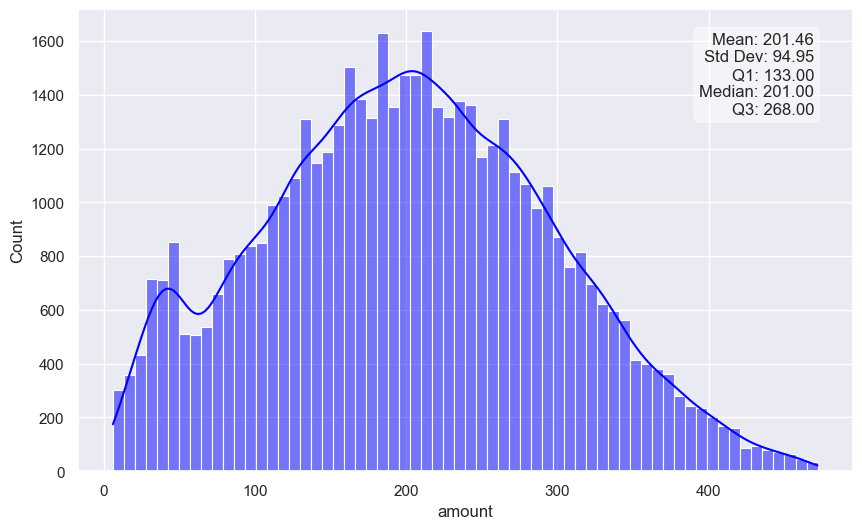

In [12]:
# Calculate statistics
mean = df['amount'].mean()
std = df['amount'].std()
q1 = df['amount'].quantile(0.25)
q2 = df['amount'].median()
q3 = df['amount'].quantile(0.75)

# Create histogram with KDE
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="amount", kde=True, color="blue")

# Add a text box with statistical information
stats_text = (
    f"Mean: {mean:.2f}\n"
    f"Std Dev: {std:.2f}\n"
    f"Q1: {q1:.2f}\n"
    f"Median: {q2:.2f}\n"
    f"Q3: {q3:.2f}"
)

plt.gca().text(
    0.95, 0.95, stats_text,
    ha='right', va='top', 
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5),
    fontsize=12,
    transform=plt.gca().transAxes
)

plt.show()

In [13]:
df["amount"].describe()

count    50253.000000
mean       201.461883
std         94.949354
min          6.000000
25%        133.000000
50%        201.000000
75%        268.000000
max        472.000000
Name: amount, dtype: float64

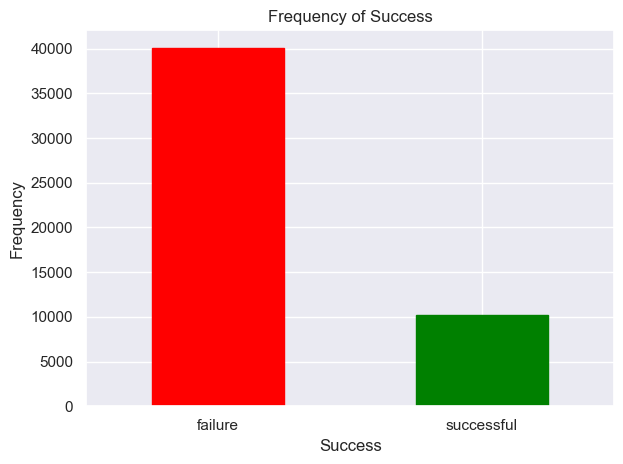

In [14]:
# Create a frequency table using crosstab
freq = pd.crosstab(index=df['success'], columns='count')
freq.columns.name = 'Frequency'
freq_df = freq.reset_index()

colors = ['red', 'green']

ax = freq_df.plot(kind='bar', x='success', y='count', legend=False)

for i, bar in enumerate(ax.patches):
    bar.set_color(colors[i % len(colors)])

ax.set_xlabel('Success')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Success')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

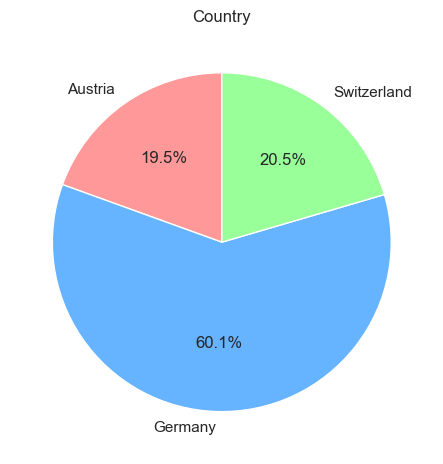

In [15]:
# Failure distribution according to country
freq=pd.crosstab(df.country, df.success)
freq['failure'].plot(kind='pie', autopct='%1.1f%%', colors=['#ff9999', '#66b3ff', '#99ff99'], startangle=90)
plt.title('Country')
plt.ylabel('') 
plt.tight_layout()
plt.show()

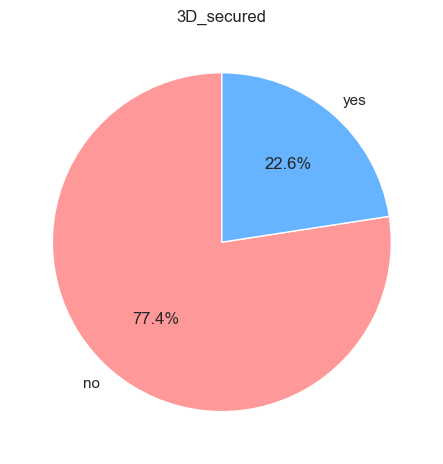

In [16]:
# Failure distribution according to 3D
freq=pd.crosstab(df['3D_secured'], df.success)
freq['failure'].plot(kind='pie', autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'], startangle=90)
plt.title('3D_secured')
plt.ylabel('') 
plt.tight_layout()
plt.show()

Text(0, 0.5, '')

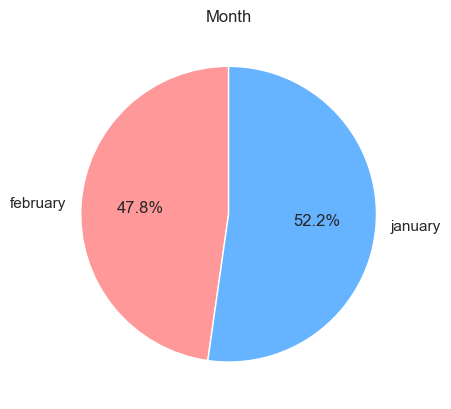

In [17]:
# Failure distribution according to month
freq=pd.crosstab(df.month, df.success)
freq['failure'].plot(kind='pie', autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'], startangle=90)
plt.title('Month')
plt.ylabel('')

Text(0, 0.5, '')

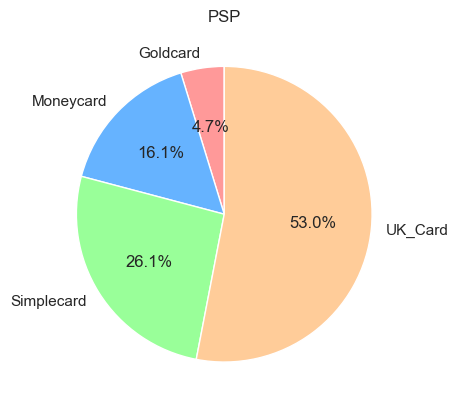

In [18]:
# Failure distribution according to PSP
freq=pd.crosstab(df.PSP, df.success)
freq['failure'].plot(kind='pie', autopct='%1.1f%%', colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'], startangle=90)
plt.title('PSP')
plt.ylabel('')

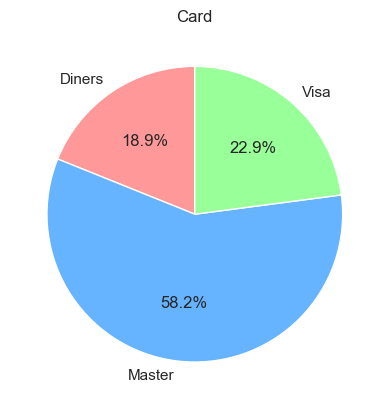

In [19]:
# Failure distribution according to cards
freq=pd.crosstab(df.card, df.success)
freq['failure'].plot(kind='pie', autopct='%1.1f%%', colors = ['#ff9999', '#66b3ff', '#99ff99'], startangle=90)
plt.title('Card')
plt.ylabel('')
plt.show()

Text(47.109375, 0.5, '')

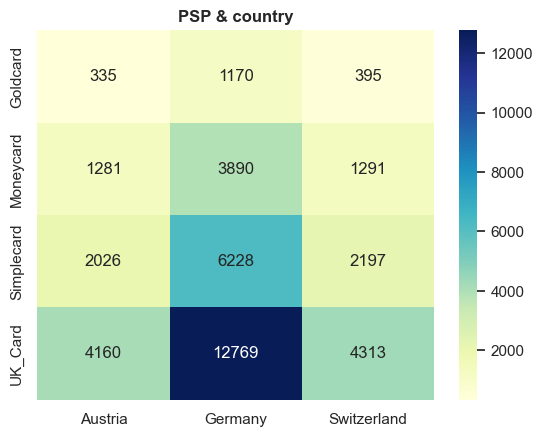

In [20]:
# Failure distribution according to PSP & country
mask=(df.success=='failure')
freq=pd.crosstab(df[mask].PSP, df[mask].country)
sns.heatmap(freq, cmap="YlGnBu", annot=True, cbar=True, fmt='d')
plt.title('PSP & country',fontsize = 12, weight='bold')
plt.xlabel("")
plt.ylabel("")

Text(47.109375, 0.5, '')

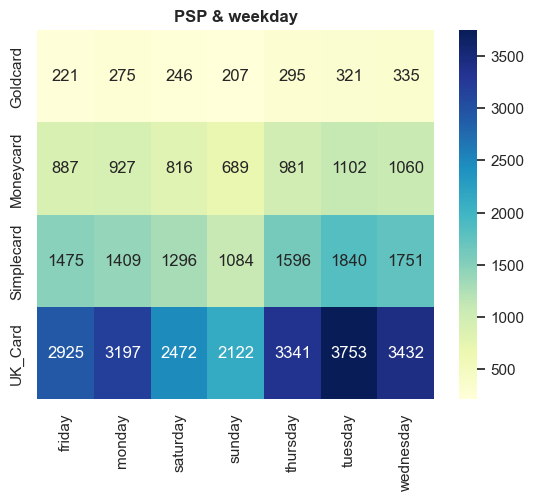

In [21]:
# Failure distribution according to PSP & weekday
mask=(df.success=='failure')
freq=pd.crosstab(df[mask].PSP, df[mask].weekday)
sns.heatmap(freq, cmap="YlGnBu", annot=True, cbar=True, fmt='d')
plt.title('PSP & weekday',fontsize = 12, weight='bold')
plt.xlabel("")
plt.ylabel("")

Text(47.109375, 0.5, '')

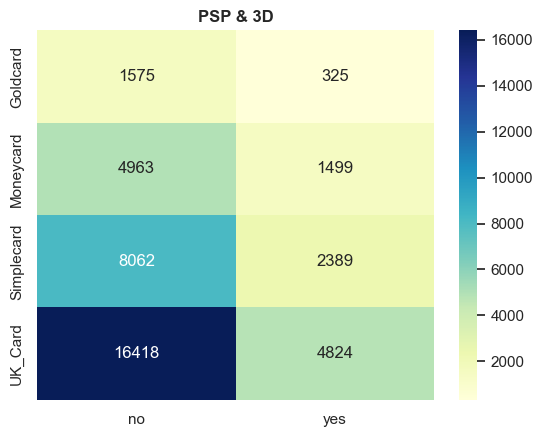

In [22]:
# Failure distribution according to PSP & 3D
mask=(df.success=='failure')
freq=pd.crosstab(df[mask].PSP, df['3D_secured'][mask])
sns.heatmap(freq, cmap="YlGnBu", annot=True, cbar=True, fmt='d')
plt.title('PSP & 3D',fontsize = 12, weight='bold')
plt.xlabel("")
plt.ylabel("")

Text(47.109375, 0.5, '')

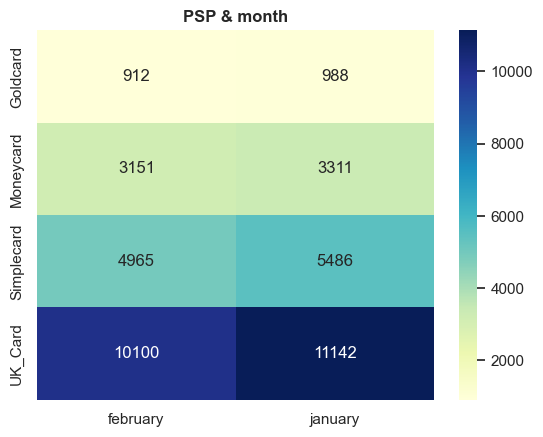

In [23]:
# Failure distribution according to PSP & month
mask=(df.success=='failure')
freq=pd.crosstab( df[mask].PSP, df[mask].month)
sns.heatmap(freq, cmap="YlGnBu", annot=True, cbar=True, fmt='d')
plt.title('PSP & month',fontsize = 12, weight='bold')
plt.xlabel("")
plt.ylabel("")

Text(47.109375, 0.5, '')

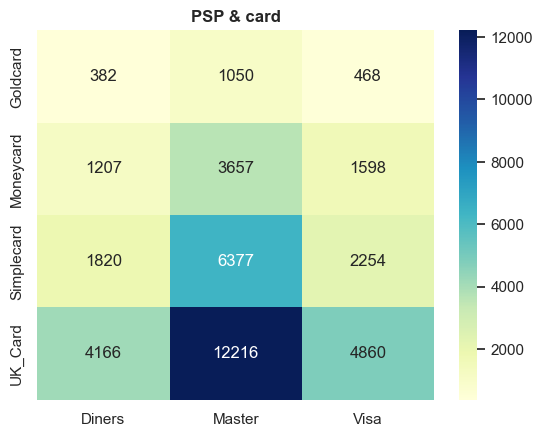

In [24]:
# Failure distribution according to PSP & card
mask=(df.success=='failure')
freq=pd.crosstab( df[mask].PSP, df[mask].card)
sns.heatmap(freq, cmap="YlGnBu", annot=True, cbar=True, fmt='d')
plt.title('PSP & card',fontsize = 12, weight='bold')
plt.xlabel("")
plt.ylabel("")

Text(47.109375, 0.5, '')

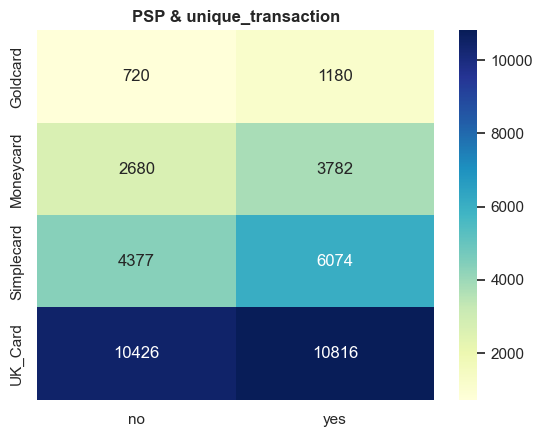

In [25]:
# Failure distribution according to PSP & unique_transaction
mask=(df.success=='failure')
freq=pd.crosstab( df[mask].PSP, df[mask].unique_transaction)
sns.heatmap(freq, cmap="YlGnBu", annot=True, cbar=True, fmt='d')
plt.title('PSP & unique_transaction',fontsize = 12, weight='bold')
plt.xlabel("")
plt.ylabel("")

Text(47.24999999999999, 0.5, '')

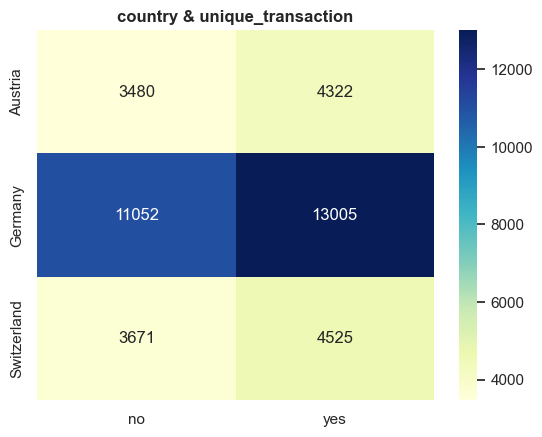

In [26]:
# Failure distribution according to country & unique_transaction
mask=(df.success=='failure')
freq=pd.crosstab( df[mask].country, df[mask].unique_transaction)
sns.heatmap(freq, cmap="YlGnBu", annot=True, cbar=True, fmt='d')
plt.title('country & unique_transaction',fontsize = 12, weight='bold')
plt.xlabel("")
plt.ylabel("")

In [27]:
#Chi-square tests for success & month
contingency_table1 = pd.crosstab(df['success'], df['month'])
chi2, p, dof, expected = chi2_contingency(contingency_table1)
print(f"\nChi-squared value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")


Chi-squared value: 0.10588399685088162
P-value: 0.7448797080107179
Degrees of freedom: 1


In [28]:
#Chi-square tests for success & weekday
contingency_table2 = pd.crosstab(df['success'], df['weekday'])
chi2, p, dof, expected = chi2_contingency(contingency_table2)
print(f"\nChi-squared value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")


Chi-squared value: 50.964564297184694
P-value: 3.0108222522712163e-09
Degrees of freedom: 6


In [29]:
#Chi-square tests for success & country
contingency_table3 = pd.crosstab(df['success'], df['country'])
chi2, p, dof, expected = chi2_contingency(contingency_table3)
print(f"\nChi-squared value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")


Chi-squared value: 1.136861777124491
P-value: 0.5664135076911376
Degrees of freedom: 2


In [30]:
#Chi-square tests for success & PSP
contingency_table4 = pd.crosstab(df['success'], df['PSP'])
chi2, p, dof, expected = chi2_contingency(contingency_table4)
print(f"\nChi-squared value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")


Chi-squared value: 990.0441343458042
P-value: 2.5992804752181485e-214
Degrees of freedom: 3


In [31]:
#Chi-square tests for success & 3D
contingency_table5 = pd.crosstab(df['success'], df['3D_secured'])
chi2, p, dof, expected = chi2_contingency(contingency_table5)
print(f"\nChi-squared value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")


Chi-squared value: 175.5590678066559
P-value: 4.519826102659138e-40
Degrees of freedom: 1


In [32]:
#Chi-square tests for success & card
contingency_table6 = pd.crosstab(df['success'], df['card'])
chi2, p, dof, expected = chi2_contingency(contingency_table6)
print(f"\nChi-squared value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")


Chi-squared value: 39.95146830816256
P-value: 2.111781032900376e-09
Degrees of freedom: 2


In [33]:
#Chi-square tests for sucess & unique_transaction
contingency_table7 = pd.crosstab(df['success'], df['unique_transaction'])
chi2, p, dof, expected = chi2_contingency(contingency_table7)
print(f"\nChi-squared value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")


Chi-squared value: 4.998202896744894
P-value: 0.025373651417829424
Degrees of freedom: 1


In [34]:
#Logistic Regression for sucess & amount
label_encoder_success = LabelEncoder()
df['success_encoded'] = label_encoder_success.fit_transform(df['success'])
X = df[['amount']] 
y = df['success_encoded'] 
X = sm.add_constant(X)
log_reg = sm.Logit(y, X).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.500567
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:        success_encoded   No. Observations:                50253
Model:                          Logit   Df Residuals:                    50251
Method:                           MLE   Df Model:                            1
Date:                Fri, 30 Aug 2024   Pseudo R-squ.:                0.007682
Time:                        11:32:21   Log-Likelihood:                -25155.
converged:                       True   LL-Null:                       -25350.
Covariance Type:            nonrobust   LLR p-value:                 1.081e-86
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9128      0.025    -36.307      0.000      -0.962      -0.863
amount        -0.0023      0.

In [35]:
#Collecting data set for the model
columns_to_select = ['success', 'weekday', 'PSP', '3D_secured', 'card','unique_transaction', 'amount']
model_df = df[columns_to_select]
model_df.shape
model_df.to_csv('model_df.csv', index=False)